### Imports

In [26]:
import sys
sys.path.append('../src')

import data_utils


import matplotlib.pyplot  as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import platform
import cv2
import tensorflow as tf
import IPython.display as display
import os



from imblearn.over_sampling import RandomOverSampler
from skimage import io, feature, util, color
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from skimage.io import imread
from tensorflow import keras
from PIL import Image
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

# 3. Data Preprocessing
----

In [2]:
# Read data
main_data = pd.read_csv("../data/raw/data_labels_mainData.csv")
extra_data = pd.read_csv("../data/raw/data_labels_extraData.csv")

# Read patient images 
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

### 3.2 Train-Val-Test Split
----

Because we observed the similarity between the images from a same patienID, we conclude that if we include images of the same patient in both the training and testing sets, data leakage might be introduced, since the model may simply memorize the images of the patients in the training set rather than learning to recognize general patterns that can be applied to new, unseen patients. To avoid this we ensure that there is no overlap between the images of patients in the sets by spliting by patientID.

Splitting the data by patient ID can also make easier to add new data to the model. When we split the data by patient ID, we can train the model on a subset of the data and then evaluate its performance on a separate subset of the data. If we later acquire new data from additional patients, we can simply add it to the training set and retrain the model. The model will then learn to recognize patterns specific to these new patients and should improve its performance on new, unseen images.

In [3]:
def split_dataset(main_data, train_ratio, val_ratio):
    """
    Split the main_data DataFrame into training, validation, and testing sets based on the patientID column.

    Parameters:
    main_data (DataFrame): the DataFrame containing the image data
    train_ratio (float): the proportion of data to allocate to the training set (e.g., 0.7 for 70%)
    val_ratio (float): the proportion of data to allocate to the validation set (e.g., 0.15 for 15%)

    Returns:
    train_data (DataFrame): the subset of main_data containing the training data
    val_data (DataFrame): the subset of main_data containing the validation data
    test_data (DataFrame): the subset of main_data containing the testing data
    """
    np.random.seed(88)
    unique_patients = np.unique(main_data['patientID'])
    np.random.shuffle(unique_patients)

    train_patients, val_test_patients = np.split(unique_patients, [int(len(unique_patients)*train_ratio)])
    val_patients, test_patients = np.split(val_test_patients, [int(len(val_test_patients)*val_ratio)])
    
    train_data = main_data[main_data['patientID'].isin(train_patients)]
    val_data = main_data[main_data['patientID'].isin(val_patients)]
    test_data = main_data[main_data['patientID'].isin(test_patients)]

    return train_data, val_data, test_data

In [4]:
train_data, val_data, test_data = split_dataset(main_data, train_ratio=0.7, val_ratio=0.55)

print("Train: ", train_data.shape)
print("Val:   ", val_data.shape)
print("Test:  ",test_data.shape)
print()

Train:  (7360, 6)
Val:    (1241, 6)
Test:   (1295, 6)



We conduct a **Sanity check** to ensure that no patient IDs are present in more than one dataset (train, validation, or test). If any IDs are present in more than one dataset, it could lead to data leakage and affect the accuracy of the model's evaluation.

In [5]:
train_patients = set(train_data['patientID'].unique())
val_patients = set(val_data['patientID'].unique())
test_patients = set(test_data['patientID'].unique())

try:
    assert len(train_patients.intersection(val_patients)) == 0
    assert len(train_patients.intersection(test_patients)) == 0
    assert len(val_patients.intersection(test_patients)) == 0
    print("No patient ID is present in more than one dataset.")
except AssertionError:
    print("Error: some patient IDs are present in multiple datasets.")

No patient ID is present in more than one dataset.


### 3.3 Evaluating the distribution in our splits
----

In [43]:
def plot_dataset_distributions(train_data, val_data, test_data, class_columns):
    """
    Plot the distributions of the given columns for the three datasets.

    Parameters:
    train_data (DataFrame): the training dataset
    val_data (DataFrame): the validation dataset
    test_data (DataFrame): the testing dataset
    class_columns (list): a list of column names to plot distributions for

    Returns:
    None
    """
    fig, axs = plt.subplots(len(class_columns), 3, figsize=(15, 5*len(class_columns)))

    for i, col in enumerate(class_columns):
        axs[i][0].hist(train_data[col], bins=10, color='blue')
        axs[i][0].set_title(f"Training Set - {col} Distribution")
        axs[i][1].hist(val_data[col], bins=10, color='green')
        axs[i][1].set_title(f"Validation Set - {col} Distribution")
        axs[i][2].hist(test_data[col], bins=10, color='orange')
        axs[i][2].set_title(f"Testing Set - {col} Distribution")
    fig.suptitle("Distribution of Dataset Classes for each set.", fontsize=16)
    plt.show()

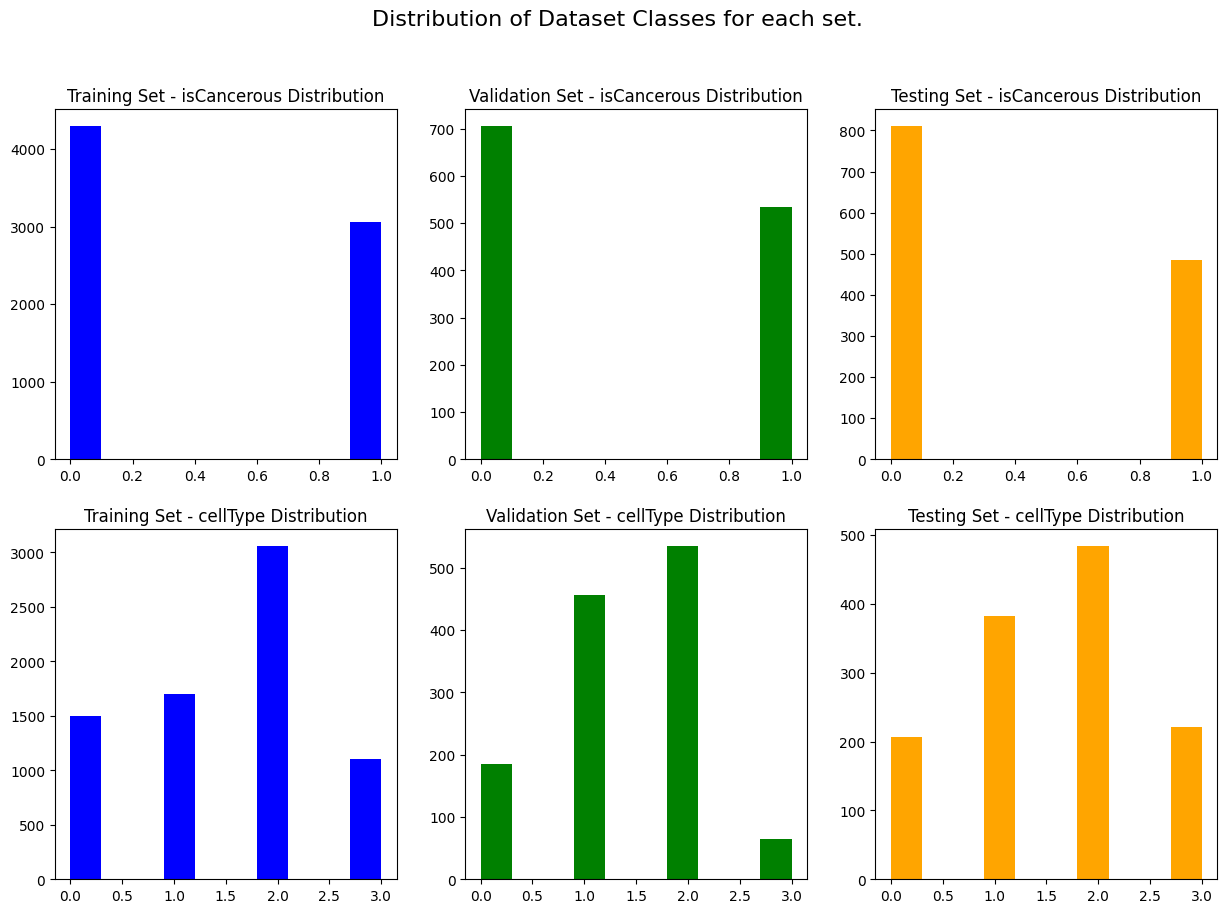

In [7]:
class_columns = ['isCancerous', 'cellType']
plot_dataset_distributions(train_data, val_data, test_data, class_columns)

In [8]:
# Perform oversampling on training data only
# oversampler = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(train_data, y_train)

Check if all images really have a consistent width and height:

### 3.4 Image Preprocessing
----


We should consider, while the model may learn to recognize specific patterns that are unique to the images from the patients in the training set, these features may not apply to images from new patients. To address this, we can consider using techniques to address the potential for overfitting, such as regularization or data augmentation to artificially increase the variation in the images. These techniques can help ensure that the model learns to recognize general patterns that are not unique to specific patients, and can help improve its ability to generalize to new, unseen patients.

To prepare the image data for use in a CNN, we will perform image preprocessing steps such as resizing, normalization, and augmentation, to improve the quality and quantity of the data.  Then pass the preprocessed images through the CNN model, which would learn to extract features from the images and classify them based on their cellType or isCancerous.


In [39]:
def generate_data_generators(data, image_folder, target_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        data_format='channels_last'
    )
    
    generator = datagen.flow_from_dataframe(
        data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return generator


In [40]:
def prepare_data(image_folder, train_data, val_data, test_data, target_size, batch_size):
    train_generator = generate_data_generators(train_data, image_folder, target_size, batch_size)
    val_generator = generate_data_generators(val_data, image_folder, target_size, batch_size)
    test_generator = generate_data_generators(test_data, image_folder, target_size, batch_size)

    return train_generator, val_generator, test_generator

In [41]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [42]:
train_generator, val_generator, test_generator \
    = prepare_data(
    image_folder=image_folder,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    target_size=(27, 27),
    batch_size=32
)

Found 7360 validated image filenames belonging to 4 classes.
Found 1241 validated image filenames belonging to 4 classes.
Found 1295 validated image filenames belonging to 4 classes.


We make use of the function to preprocess_data to preprocess our data. This function creates data generators for the train, validation, and test sets using the ImageDataGenerator class from Keras. The generators preprocess the image data by applying various techniques. The training set is augmented with various transformations such as rotation, width shift, height shift, shear, zoom, and horizontal flip, whereas the validation and test sets are only rescaled. The rescale parameter scales the pixel values of the images to a range of 0 to 1.  

 The output dictionary contains the generators for the train, validation, and test sets, as well as the number of samples in each set. We will use these generators to train our model.

# 4. Model Evaluation Set-up
----

To evaluate out baseline model's performance on the test set, we will be using appropriate evaluation metrics for multi-class classification. 

Common metrics to considered:

- **Accuracy**: Calculate the overall accuracy of the model, which measures the proportion of correctly classified samples.
- **Precision**: Compute the precision for each class, which measures the proportion of correctly predicted samples among the predicted samples for that class.
- **Recall**: Calculate the recall for each class, which measures the proportion of correctly predicted samples among the actual samples of that class.
- **F1-Score**: Compute the F1-score for each class, which is the harmonic mean of precision and recall and provides a balanced measure of a model's performance.

In [12]:
# Function: def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy')
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# 5. Model Development
----

### 5.1 Baseline Model
----

In [13]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

model_base = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



**Model Summary**


In [14]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

### 5.2 Training and Evaluation of Baseline Model using Categorical Crossentropy Loss and SGD Optimizer
----

In [15]:
model_base.compile(optimizer='SGD',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy'])

In [16]:
history_base = model_base.fit(train_generator, 
                              validation_data=val_generator, 
                              epochs=25, 
                              verbose=0)

2023-05-15 19:03:20.667906: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
model_base.evaluate(val_generator)

39/39 [==============================] - 0s 8ms/step - loss: 0.7677 - categorical_accuracy: 0.7188


[0.7676539421081543, 0.7187751531600952]

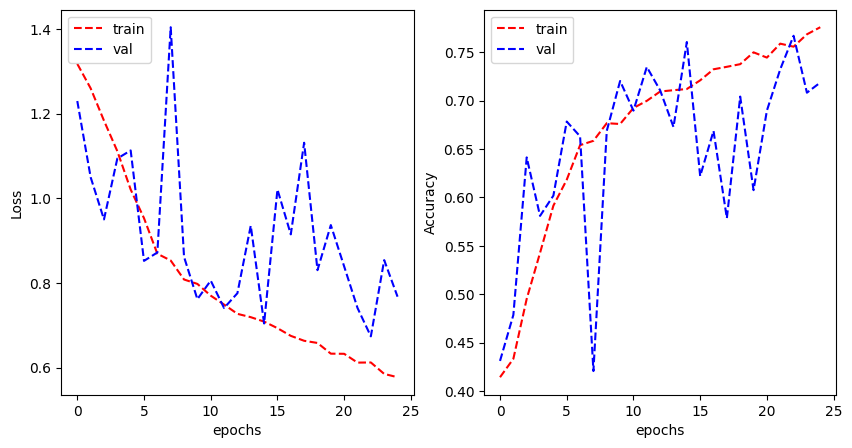

In [18]:
plot_learning_curve(history_base.history['loss'], 
                    history_base.history['val_loss'], 
                    history_base.history['categorical_accuracy'], 
                    history_base.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### 5.3 Bseline Model Visualization of Ground Truth and Predicted Labels for Validation Data Samples
----

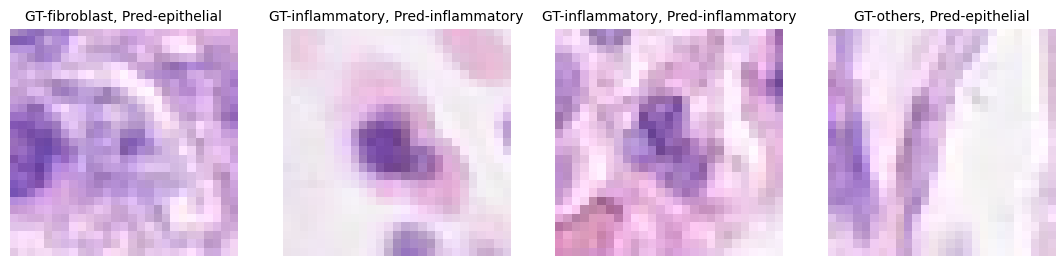

In [19]:
label_map = {'fibroblast':0 , 'inflammatory': 1, 'epithelial': 2, 'others': 3}

d_inv = {v: k for k, v in label_map.items()}
plt.figure(figsize=(17,3))
batches = 0
for x,y in val_generator:
        batches = batches + 1
        y_hat = model_base.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(np.squeeze(x[0]))
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]), fontsize=10)
            
        else:
            break
        
        plt.axis('off')

In [36]:
def plot_confusion_matrix(y_true, y_prediction):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_prediction)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

39/39 [==============================] - 0s 9ms/step
[[0.16236162 0.140625   0.14829659 0.17391304]
 [0.36162362 0.38839286 0.35470942 0.34782609]
 [0.42804428 0.41964286 0.44088176 0.47826087]
 [0.04797048 0.05133929 0.05611222 0.        ]]


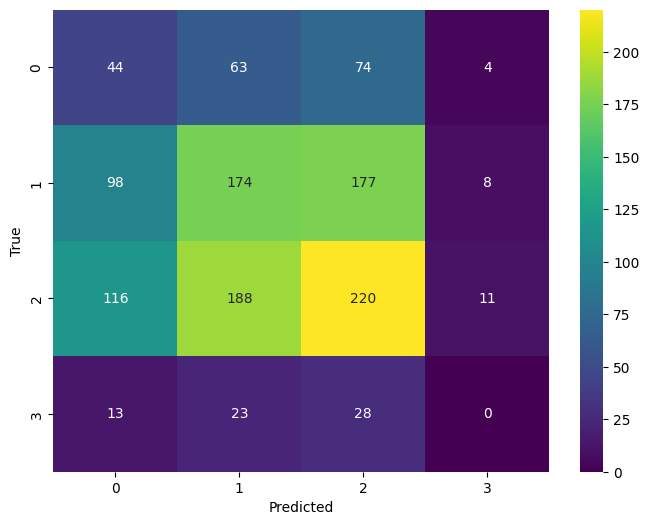

In [35]:
y_prediction = model_base.predict(val_generator)
y_prediction = np.argmax(y_prediction, axis=1)
y_true = val_generator.labels
result = confusion_matrix(y_true, y_prediction, normalize='pred')
print(result)

plot_confusion_matrix(y_true, y_prediction)


### 5.4 Generation of Augmented Data Generators for Training, Validation, and Test Data
----

In [20]:
# Function: def generate_augmented_data_generators
def generate_augmented_data_generators(data, image_folder, target_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        data_format='channels_last'
    )
    
    generator = datagen.flow_from_dataframe(
        data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return generator

# Prepare the image data and returns a dictionary containing the preprocessed train, validation, and test data:
def prepare_data(image_folder, train_data, val_data, test_data, target_size, batch_size):
    train_generator = generate_augmented_data_generators(train_data, image_folder, target_size, batch_size)
    val_generator = generate_augmented_data_generators(val_data, image_folder, target_size, batch_size)
    test_generator = generate_augmented_data_generators(test_data, image_folder, target_size, batch_size)

    return train_generator, val_generator, test_generator

In [21]:
train_generator_aug, val_generator_aug, test_generator_aug \
    = prepare_data(
    image_folder=image_folder,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    target_size=(27, 27),
    batch_size=32
)

Found 7360 validated image filenames belonging to 4 classes.
Found 1241 validated image filenames belonging to 4 classes.
Found 1295 validated image filenames belonging to 4 classes.


In [22]:
history_base = model_base.fit(train_generator_aug, 
                              validation_data=val_generator_aug, 
                              epochs=25, 
                              verbose=0)

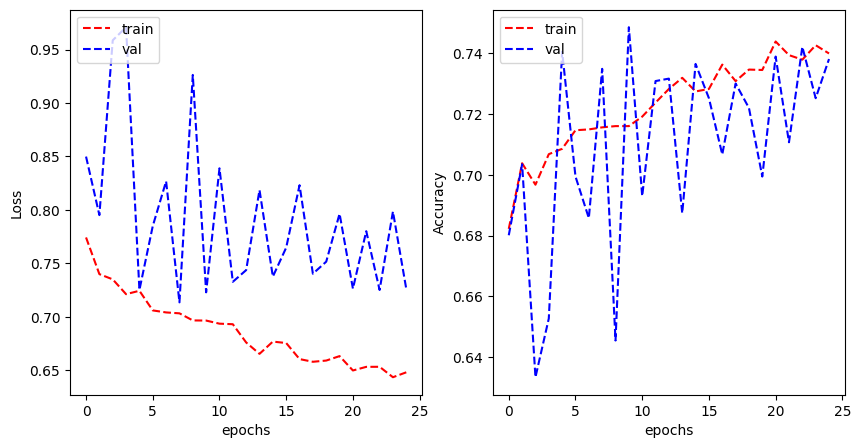

In [23]:
plot_learning_curve(history_base.history['loss'], history_base.history['val_loss'], 
                    history_base.history['categorical_accuracy'], history_base.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')